# Toxic comments detection
In the following notebook we will examine toxic comment detection using transformers (BERT). In the end, we compare BERT with baseline model.

The notebook based on [detoxify](https://github.com/unitaryai/detoxify).

In [1]:
import pandas as pd
import torch
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch.nn as nn
import pytorch_lightning as pl
from torch.nn import functional as F
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from torchmetrics import Accuracy

from transformers import BertTokenizer
from transformers import BertForSequenceClassification

from sklearn.model_selection import train_test_split

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
import gensim.downloader

from pytorch_lightning.loggers.logger import Logger, rank_zero_experiment
from pytorch_lightning.utilities import rank_zero_only

## Data loading
Let's use data from [kaggle competition](https://www.kaggle.com/competitions/jigsaw-toxic-comment-classification-challenge/data).

Unfortunetely, data has to be downloaded manually. Required file: `train.csv.zip`

In [2]:
!unzip -o "/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv.zip" "train.csv"

Archive:  /kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv.zip
  inflating: train.csv               


Read data, split on train and validation

In [3]:
data = pd.read_csv("train.csv")
train_data, val_data = train_test_split(data, test_size=0.3, random_state=42)

Visualize a few examples

In [4]:
train_data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
54568,91da4b4b95fe5e2d,"""\n\nConflict of interest note\nBy your user n...",0,0,0,0,0,0
3786,0a1df25805d6d2e7,"(update: actually, I changed this to something...",0,0,0,0,0,0
22938,3c9e75d2b8dcf720,"MRCA article \nSniperz11, thanks for your comm...",0,0,0,0,0,0
137856,e1b03f4baf9d58ce,Arguing that BART and Caltrain should get more...,0,0,0,0,0,0
143038,fcdf5d299437f2a9,"""\n\n Blocked \nHi, I blocked you for 24 hour...",0,0,0,0,0,0


We see that there are six labels for different types of toxicity.

## Common training definitions

Set training params

In [5]:
BATCH_SIZE = 16
NUM_LABELS = 6

Get device

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Create dataset, which supplies text and its labels

In [7]:
class TextsDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        text = row["comment_text"]
        labels = torch.tensor(row[(row.index != "comment_text") & (row.index != "id")].values.astype(np.float32))
        return text, labels

In [8]:
train_dataset = TextsDataset(train_data)
val_dataset = TextsDataset(val_data)

Define dataloaders

In [9]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

Create custom logger (we will track loss and accuracy during training)

In [10]:
class StatisticsLogger(Logger):
    def __init__(self):
        super().__init__()
        self.history = {"val_loss": [], "val_acc": []}
    
    @property
    def name(self):
        return "StatisticsLogger"

    @property
    def version(self):
        return "0.1"

    @rank_zero_only
    def log_hyperparams(self, params):
        pass

    @rank_zero_only
    def save(self):
        pass

    @rank_zero_only
    def finalize(self, status):
        pass
    
    @rank_zero_only
    def log_metrics(self, metrics, step):
        self.history["val_loss"].append(metrics["val_loss"])
        self.history["val_acc"].append(metrics["val_acc"])

## Transformer (BERT)
We will use BERT as our main model for multilabel classification.

First, we need to define tokenizer for text. We will use BERT [tokenizer](https://huggingface.co/docs/transformers/main_classes/tokenizer).

Example of its work:

In [11]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [12]:
sample_encoding = tokenizer.encode('As every cat owner knows, nobody owns a cat.')
print(sample_encoding)
print(tokenizer.convert_ids_to_tokens(sample_encoding))

[101, 2004, 2296, 4937, 3954, 4282, 1010, 6343, 8617, 1037, 4937, 1012, 102]
['[CLS]', 'as', 'every', 'cat', 'owner', 'knows', ',', 'nobody', 'owns', 'a', 'cat', '.', '[SEP]']


Define classifier

In [13]:
class ToxicClassifier(pl.LightningModule):
    def __init__(self):
        super().__init__()
        # Model and tokenizer
        self.model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=NUM_LABELS)
        self.tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
        # Statistics functions
        self.loss = F.binary_cross_entropy_with_logits
        self.accuracy = Accuracy(task="multilabel", num_labels=NUM_LABELS)

    def forward(self, x):
        tokens = self.tokenizer(x, return_tensors="pt", truncation=True, padding=True).to(device)
        outputs = self.model(**tokens)[0]
        return outputs
    
    def eval_predictions(self, output):
        return (torch.sigmoid(output) > 0.5).to(torch.int32)
    
    def step(self, batch):
        # Forward
        x, y = batch
        output = self.forward(x)
        preds = self.eval_predictions(output)
        # Statistics
        loss = self.loss(output, y)
        acc = self.accuracy(preds, y)
        return loss, acc

    def training_step(self, batch, batch_idx):
        loss, acc = self.step(batch)
        return {"loss": loss, "acc": acc}
    
    def validation_step(self, batch, batch_idx):
        loss, acc = self.step(batch)
        self.log_dict({"val_loss": loss, "val_acc": acc})
    
    def predict_step(self, batch, batch_idx):
        return self.eval_predictions(self.forward(batch))

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=3e-5, weight_decay=3e-6, amsgrad=True)

Start training

In [14]:
# Model
bert_model = ToxicClassifier()

# Logger
bert_logger = StatisticsLogger()

# Trainer
bert_trainer = pl.Trainer(max_epochs=1, accelerator=device.type, val_check_interval=0.1, logger=bert_logger)

# Start training
bert_trainer.fit(bert_model, train_dataloader, val_dataloader)

# Save model
bert_trainer.save_checkpoint("toxic_classifier.ckpt")

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

## Baseline model

For a baseline model we need first some [nlp-preprocessing](https://datastud.dev/posts/nlp-preprocess): create a simple tokenizer, then get embeddings for each of the words and combine them into a single one. For simplicity all embeddings will be averaged.

In the next cell we download glove model for word embeddings:

In [15]:
glove_embeddings = gensim.downloader.load("glove-wiki-gigaword-100")

[==================================================] 100.0% 128.1/128.1MB downloaded


Define custom tokenizer

In [16]:
def baseline_tokenizer(text_batch):
    def text_tokenizer(text):
        # Split text, remove stopwords and punctuation, get embedding
        tokens = [glove_embeddings[token] for token in map(lambda word: word.lower(), word_tokenize(text))
                  if token not in stopwords.words('english')
                  and token not in set(string.punctuation)
                  and token in glove_embeddings]

        # Average embeddings
        if len(tokens) == 0:
            return torch.zeros(100, dtype=torch.float32)
        else:
            return torch.tensor(tokens, dtype=torch.float32).mean(axis=0)
    
    
    if isinstance(text_batch, str):
        return text_tokenizer(text_batch)
    else:
        embeddings = []
        for text in text_batch:
            embeddings.append(text_tokenizer(text))
        return torch.stack(embeddings)

As a baseline model, we can take a simple neural network consisted of a few fully connected layers.

In [19]:
class BaselineToxicClassifier(pl.LightningModule):
    def __init__(self):
        super().__init__()
        
        # Define layers
        self.relu = nn.ReLU()
        self.layer1 = nn.Linear(100, 256)
        self.layer2 = nn.Linear(256, 256)
        self.layer3 = nn.Linear(256, 256)
        self.layer4 = nn.Linear(256, 256)
        self.layer5 = nn.Linear(256, NUM_LABELS)
        
        # Define loss and accuracy
        self.loss = F.binary_cross_entropy_with_logits
        self.accuracy = Accuracy(task="multilabel", num_labels=NUM_LABELS)

    def forward(self, x):
        x = baseline_tokenizer(x).to(device)
        
        x = self.layer1(x)
        x = self.relu(x)
        
        x = self.layer2(x)
        x = self.relu(x)
        
        x = self.layer3(x)
        x = self.relu(x)
        
        x = self.layer4(x)
        x = self.relu(x)
        
        x = self.layer5(x)
        
        return x

    def eval_predictions(self, output):
        return (torch.sigmoid(output) > 0.5).to(torch.int32)
    
    def step(self, batch):
        # Forward
        x, y = batch
        output = self.forward(x)
        preds = self.eval_predictions(output)
        # Statistics
        loss = self.loss(output, y)
        acc = self.accuracy(preds, y)
        return loss, acc

    def training_step(self, batch, batch_idx):
        loss, acc = self.step(batch)
        return {"loss": loss, "acc": acc}
    
    def validation_step(self, batch, batch_idx):
        loss, acc = self.step(batch)
        self.log_dict({"val_loss": loss, "val_acc": acc})

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=3e-5, weight_decay=3e-6, amsgrad=True)

Start training

In [20]:
# Model
baseline_model = BaselineToxicClassifier()

# Logger
baseline_logger = StatisticsLogger()

# Trainer
baseline_trainer = pl.Trainer(max_epochs=1, accelerator=device.type, val_check_interval=0.1, logger=baseline_logger)

# Start training
baseline_trainer.fit(baseline_model, train_dataloader, val_dataloader)

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

## Results

Function for visualization using statistics from logger

In [21]:
def visualize_statistics(logger, model):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].plot(logger.history["val_acc"])
    axs[0].set(xlabel='Iteration', ylabel='Accuracy', title=f'{model} accuracy')
    axs[0].grid()

    axs[1].plot(logger.history["val_loss"])
    axs[1].set(xlabel='Iteration', ylabel='Loss', title=f'{model} loss')
    axs[1].grid()

    plt.show()

Visualize bert statistics

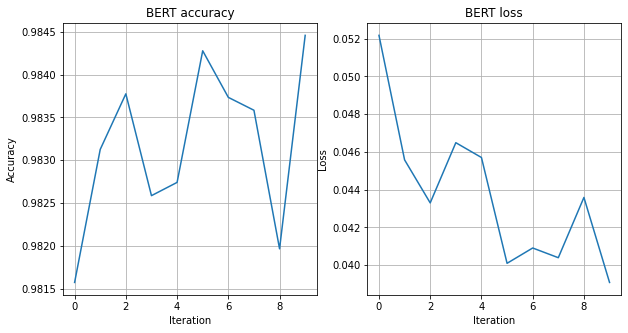

In [22]:
visualize_statistics(bert_logger, "BERT")

Visualize baseline statistics

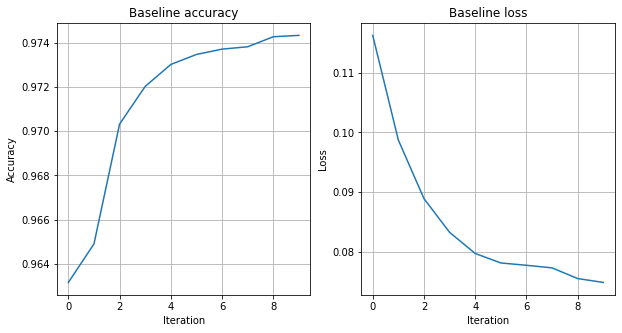

In [23]:
visualize_statistics(baseline_logger, "Baseline")

We can conclude that BERT outperforms baseline model and helps increase accuracy significantly.